**Stroke Prediction**

Kişinin gelecekte inme yaşayıp yaşamayacağını tahmin etmeye çalışan bir veri bilimi projesidir.

**Neden bu proje?**

İnme dünya genelinde ölüm sebeplerinin başında geliyor.
Erken risk tespiti yapılırsa önleyici tedbirler alınabilir (yaşam tarzı değişiklikleri, ilaç vb.).
Hastaneler, sigorta şirketleri, sağlık kuruluşları bu tahmini kullanabiliyor.

Not: İnme ve felç aynı şey değildir. İnme, beyne giden kan akışının aniden kesilmesi veya azalmasıdır.
Bu durum oksijen eksikliğine yol açar ve beyin hücreleri ölür. Felç, kasların hareket edememesidir.
Felç, inmenin sonucunda ortaya çıkabilir.


In [3]:
#Kullanacağımız kütüphaneleri ekledik.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

# Sadece FutureWarning türündeki uyarıları görmezden gel
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
#Csv dosyamızı yükledik ve tanımladık.

df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [5]:
#Tüm veriyi yazdırdık.

print(df)

         id  gender   age  hypertension  heart_disease ever_married  \
0      9046    Male  67.0             0              1          Yes   
1     51676  Female  61.0             0              0          Yes   
2     31112    Male  80.0             0              1          Yes   
3     60182  Female  49.0             0              0          Yes   
4      1665  Female  79.0             1              0          Yes   
...     ...     ...   ...           ...            ...          ...   
5105  18234  Female  80.0             1              0          Yes   
5106  44873  Female  81.0             0              0          Yes   
5107  19723  Female  35.0             0              0          Yes   
5108  37544    Male  51.0             0              0          Yes   
5109  44679  Female  44.0             0              0          Yes   

          work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0           Private          Urban             228.69  36.6  former

In [6]:
#Verilerimiz hakkında özet aldık.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
#Veri temizleme adımına geçmeden önce nerelerde eksik olduğuna baktık (sütun bazında).

print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [8]:
#Eksik bmi değerinin veri setindeki eksikliği; (yüzde olarak)

df['bmi'].isnull().mean() * 100

np.float64(3.9334637964774952)

In [9]:
#Eksik veriler %4 olduğu için silindi. (veri setinde çok büyük bir kayıp değil modeli etkilemez)

df = df.dropna(subset=['bmi'])

In [10]:
#Tekrardan eksik kaldı mı kontrolü

print(df.isnull().sum())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [11]:
#Boxplot görselleştirmesi için sayısal değerden farklı sütun var mı baktık.

df.select_dtypes(exclude='number').columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

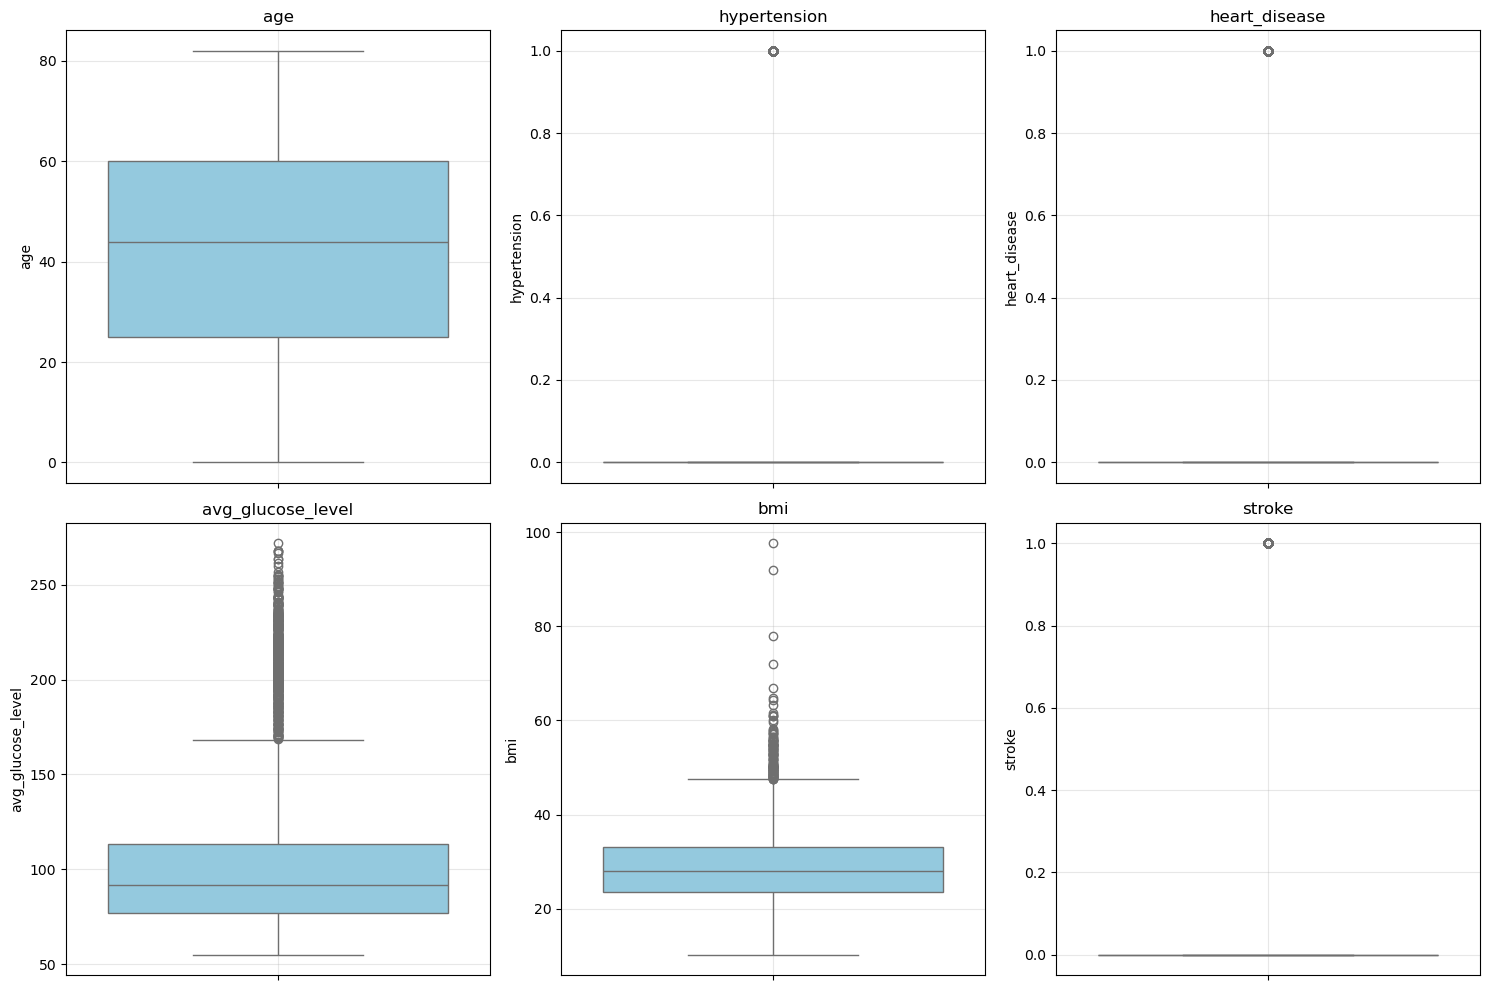

In [12]:
#Eksikler tamamlandı.
#Sütunlarda aykırı değer tespiti için önce boxplot görselleştirmesi yaptık.

# Sayısal sütunları seç (id hariç)

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'id' in numeric_cols:
    numeric_cols.remove('id')

# Grafik yerleşimi için satır ve sütun sayısını hesapla

num_cols = 3  # Yan yana 3 grafik olsun
num_rows = math.ceil(len(numeric_cols) / num_cols)

plt.figure(figsize=(15, 5 * num_rows))

for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=df[col], color='skyblue') # Dikey boxplot daha yaygındır çoklu gösterimde
    plt.title(col, fontsize=12)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('all_columns_boxplot.png')

Alt Sınır: 22.32
Üst Sınır: 168.32
Tespit Edilen Aykırı Değer Sayısı: 567


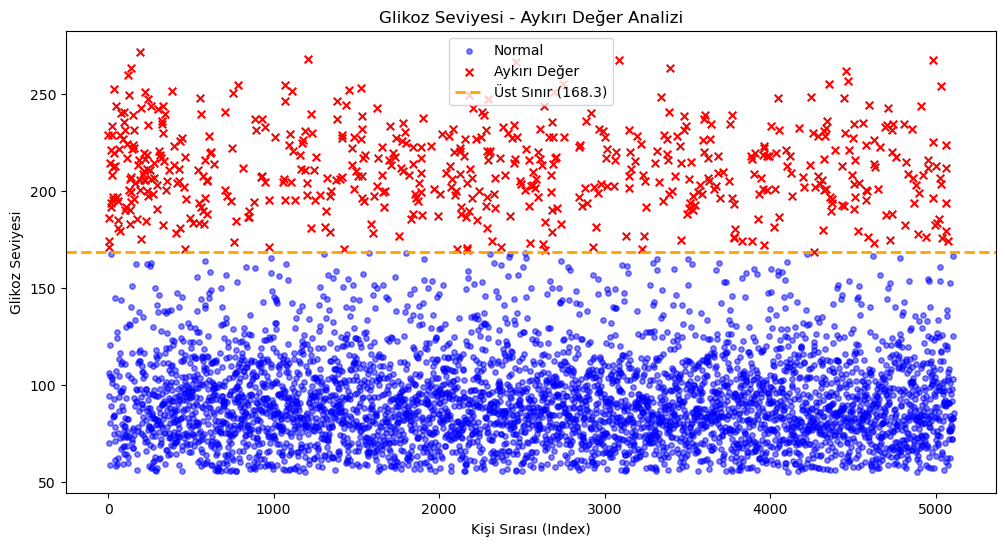

In [13]:
#Boxplotta görünen glikoz seviyesi için iqr aykırı değer tespiti yaptık.

col_name = 'avg_glucose_level'

#IQR Hesaplama

Q1 = df[col_name].quantile(0.25)
Q3 = df[col_name].quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

#Aykırı ve Normal Verileri Ayırma

aykiri_olanlar = df[(df[col_name] < alt_sinir) | (df[col_name] > ust_sinir)]
normal_olanlar = df[(df[col_name] >= alt_sinir) & (df[col_name] <= ust_sinir)]

print(f"Alt Sınır: {alt_sinir:.2f}")
print(f"Üst Sınır: {ust_sinir:.2f}")
print(f"Tespit Edilen Aykırı Değer Sayısı: {len(aykiri_olanlar)}")

#Görselleştirme (Scatter Plot)

plt.figure(figsize=(12, 6))

#Normal verileri mavi çiz

plt.scatter(normal_olanlar.index, normal_olanlar[col_name], color='blue', label='Normal', alpha=0.5, s=15)

#Aykırı verileri kırmızı çiz

plt.scatter(aykiri_olanlar.index, aykiri_olanlar[col_name], color='red', label='Aykırı Değer', s=30, marker='x')

#Sınır çizgisini ekle

plt.axhline(y=ust_sinir, color='orange', linestyle='--', linewidth=2, label=f'Üst Sınır ({ust_sinir:.1f})')

plt.title('Glikoz Seviyesi - Aykırı Değer Analizi')
plt.xlabel('Kişi Sırası (Index)')
plt.ylabel('Glikoz Seviyesi')
plt.legend()
plt.show()

Alt Sınır: 9.10
Üst Sınır: 47.50
Tespit Edilen Aykırı Değer Sayısı: 110


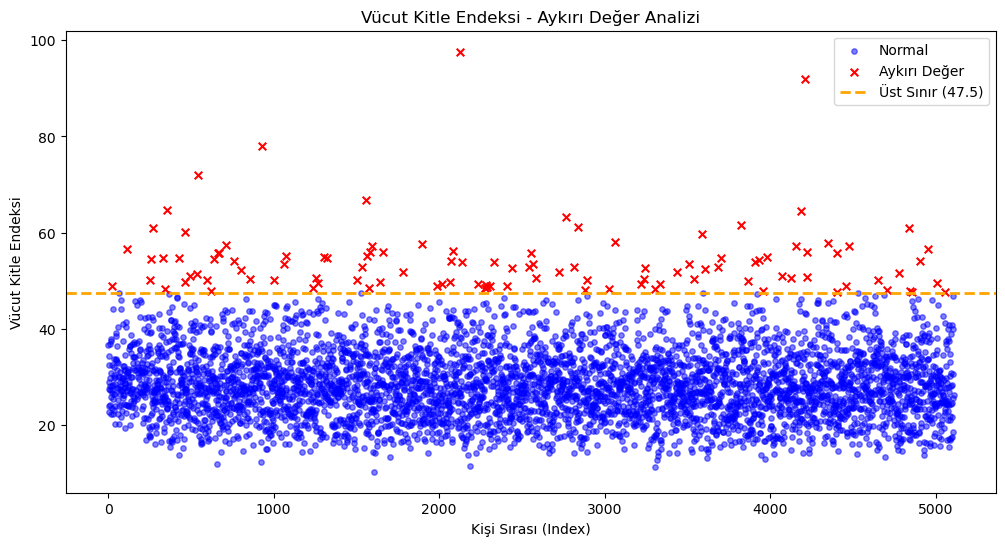

In [14]:
#Boxplotta görünen bmi(vücut kitle endeksi) için iqr aykırı değer tespiti yaptık.

col_name = 'bmi'

#IQR Hesaplama

Q1 = df[col_name].quantile(0.25)
Q3 = df[col_name].quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

#Aykırı ve Normal Verileri Ayırma

aykiri_olanlar = df[(df[col_name] < alt_sinir) | (df[col_name] > ust_sinir)]
normal_olanlar = df[(df[col_name] >= alt_sinir) & (df[col_name] <= ust_sinir)]

print(f"Alt Sınır: {alt_sinir:.2f}")
print(f"Üst Sınır: {ust_sinir:.2f}")
print(f"Tespit Edilen Aykırı Değer Sayısı: {len(aykiri_olanlar)}")

#Görselleştirme (Scatter Plot)

plt.figure(figsize=(12, 6))

#Normal verileri mavi çiz

plt.scatter(normal_olanlar.index, normal_olanlar[col_name], color='blue', label='Normal', alpha=0.5, s=15)

#Aykırı verileri kırmızı çiz

plt.scatter(aykiri_olanlar.index, aykiri_olanlar[col_name], color='red', label='Aykırı Değer', s=30, marker='x')

#Sınır çizgisini ekle

plt.axhline(y=ust_sinir, color='orange', linestyle='--', linewidth=2, label=f'Üst Sınır ({ust_sinir:.1f})')

plt.title('Vücut Kitle Endeksi - Aykırı Değer Analizi')
plt.xlabel('Kişi Sırası (Index)')
plt.ylabel('Vücut Kitle Endeksi')
plt.legend()
plt.show()

In [15]:
#Buradaki aykırı değerler inme inme olasılığını hesaplarken asıl sıkıntı teşkil eden grup olabileceğinden silmedik.

In [16]:
#Yanlış tipte değer var mı kontrolü

df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [17]:
#Duplicate (tekrar eden satır) temizleme

df.duplicated().sum()

np.int64(0)

In [18]:
#Veri setindeki kategorik değişkenlerdeki farklı olanları inceledik.

for col in df.select_dtypes(include=['object']).columns:
    print(col, ":", df[col].unique())

gender : ['Male' 'Female' 'Other']
ever_married : ['Yes' 'No']
work_type : ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type : ['Urban' 'Rural']
smoking_status : ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [19]:
df['gender'].value_counts()

gender
Female    2897
Male      2011
Other        1
Name: count, dtype: int64

In [20]:
#1 tane other değerinin modele katkısı olamadığı için siliyoruz

df = df[df['gender'] != 'Other']

In [21]:
#Kişinin sigara içip içmediğini bilmemesi doğru bir parametre olmadığı için NAN değere çevrilir.

df['smoking_status'] = df['smoking_status'].replace('Unknown', np.nan)

In [22]:
#Düzenlediğimiz veri setini inceleme adımına geçiyoruz.

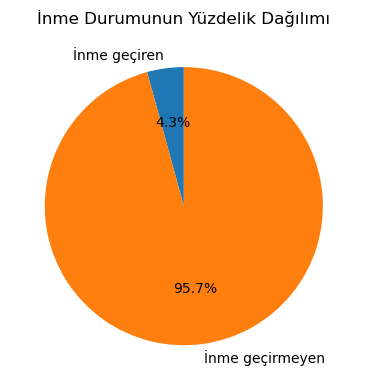

In [ ]:
#Projemiz bir sınıflandırma problemi olduğundan genel inme dağılımını incelemekle başlıyoruz

stroke_count = df["stroke"].sum()
no_stroke_count = len(df) - stroke_count

labels = ["İnme geçiren", "İnme geçirmeyen"]
sizes = [stroke_count, no_stroke_count]

plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("İnme Durumunun Yüzdelik Dağılımı")
plt.tight_layout()
plt.show()

In [24]:
#Kategorik değişkenlerin genel dağılımını ve bunların inme ile ilişkilerini incelemeye başlayalım

kategorik_degiskenler = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']

for col in kategorik_degiskenler:
    print("*****", col, "*****")
    print(df[col].value_counts())
    print("--- İnme oranı (%) ---")
    print(df.groupby(col)['stroke'].mean().sort_values(ascending=False) * 100)
    print()

***** gender *****
gender
Female    2897
Male      2011
Name: count, dtype: int64
--- İnme oranı (%) ---
gender
Male      4.425659
Female    4.142216
Name: stroke, dtype: float64

***** hypertension *****
hypertension
0    4457
1     451
Name: count, dtype: int64
--- İnme oranı (%) ---
hypertension
1    13.303769
0     3.343056
Name: stroke, dtype: float64

***** heart_disease *****
heart_disease
0    4665
1     243
Name: count, dtype: int64
--- İnme oranı (%) ---
heart_disease
1    16.460905
0     3.622722
Name: stroke, dtype: float64

***** ever_married *****
ever_married
Yes    3204
No     1704
Name: count, dtype: int64
--- İnme oranı (%) ---
ever_married
Yes    5.805243
No     1.349765
Name: stroke, dtype: float64

***** work_type *****
work_type
Private          2810
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: count, dtype: int64
--- İnme oranı (%) ---
work_type
Self-employed    6.838710
Private          4.519573
Govt_job         4

In [25]:
# Veri setindeki kategorik değişkenlerin inme ile ilişkisi incelendiğinde:

#Hipertansiyon ve kalp hastalığı inme riskini en güçlü şekilde artıran iki değişkendir. Her iki durumda da inme oranı normallerin yaklaşık 4 katıdır.
#Evli olmak, serbest çalışan olmak ve önceden sigara kullanan grubunda yer almak inme oranlarını artırmaktadır; ancak bu artışların büyük kısmının yaş etkisi ile ilişkili olduğu düşünülmektedir.
#Cinsiyet ve yaşanılan yer (kırsal/şehir) inme riski açısından belirgin bir farklılık göstermemektedir.

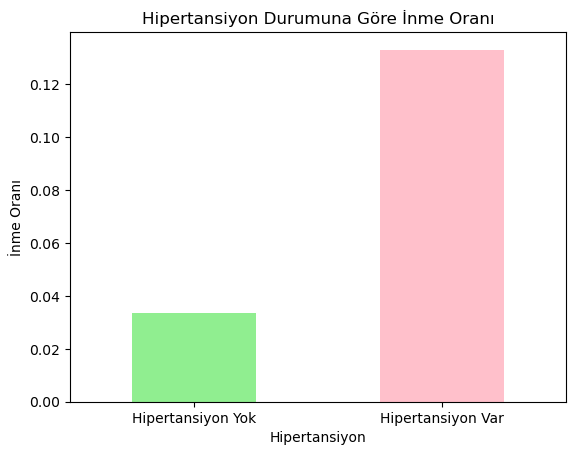

In [26]:
#Önemli gördüğümüz kategorilerin inme ile ilişkilerini görsel olarakta görelim
#### Hipertansiyon ve inme oranı
stroke_rate = df.groupby("hypertension")["stroke"].mean()
stroke_rate.plot(kind='bar', color=['lightgreen','pink'])
plt.xlabel("Hipertansiyon")
plt.ylabel("İnme Oranı")
plt.title("Hipertansiyon Durumuna Göre İnme Oranı")
plt.xticks([0,1], ["Hipertansiyon Yok", "Hipertansiyon Var"], rotation=0)
plt.show()
#Grafikten anlayabileceğimiz üzere hipertansiyonu olan kişilerin inme geçirme oranının daha yüksek olduğunu gözlemliyoruz

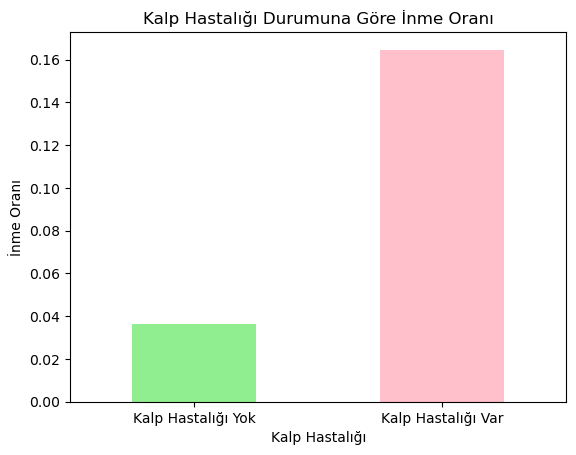

In [27]:
#### Kalp rahatsızlığı ve inme oranı
stroke_rate = df.groupby("heart_disease")["stroke"].mean()
stroke_rate.plot(kind='bar', color=['lightgreen','pink'])
plt.xlabel("Kalp Hastalığı")
plt.ylabel("İnme Oranı")
plt.title("Kalp Hastalığı Durumuna Göre İnme Oranı")
plt.xticks([0,1], ["Kalp Hastalığı Yok", "Kalp Hastalığı Var"], rotation=0)
plt.show()

In [ ]:
#Sayısal değişkenlerin genel dağılımını ve bunların inme ile ilişkilerini incelemeye başlayalım
sayisal_degiskenler = ['age', 'bmi', 'avg_glucose_level']

for col in sayisal_degiskenler:
    print("*****", col, "*****")
    print(df[col].describe())
    print("--- İnme durumuna göre ortalama ---")
    print(df.groupby("stroke")[col].mean())

***** age *****
count    4908.000000
mean       42.868810
std        22.556128
min         0.080000
25%        25.000000
50%        44.000000
75%        60.000000
max        82.000000
Name: age, dtype: float64
--- İnme durumuna göre ortalama ---
stroke
0    41.763805
1    67.712919
Name: age, dtype: float64
***** bmi *****
count    4908.00000
mean       28.89456
std         7.85432
min        10.30000
25%        23.50000
50%        28.10000
75%        33.10000
max        97.60000
Name: bmi, dtype: float64
--- İnme durumuna göre ortalama ---
stroke
0    28.824431
1    30.471292
Name: bmi, dtype: float64
***** avg_glucose_level *****
count    4908.000000
mean      105.297402
std        44.425550
min        55.120000
25%        77.067500
50%        91.680000
75%       113.495000
max       271.740000
Name: avg_glucose_level, dtype: float64
--- İnme durumuna göre ortalama ---
stroke
0    103.995367
1    134.571388
Name: avg_glucose_level, dtype: float64


<Axes: >

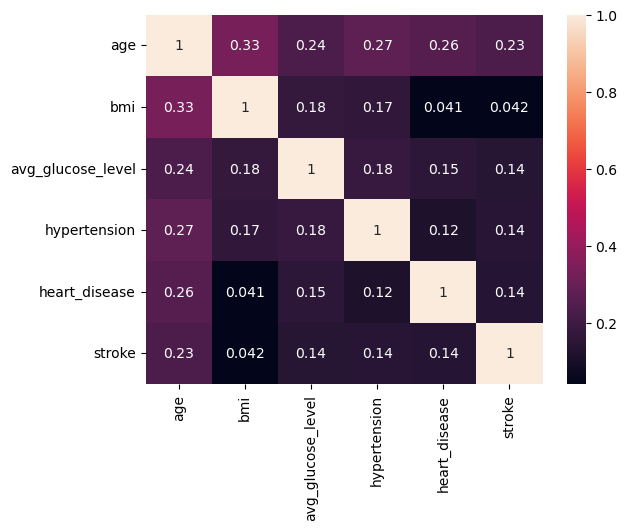

In [ ]:
#Sayısal değişkenlerin arasındaki korelasyonu görmek adına ısı grafiği oluşturduk
sns.heatmap(df[['age','bmi','avg_glucose_level','hypertension','heart_disease','stroke']].corr(), annot=True)
# Yaş, inme için en güçlü sayısal göstergedir, yaşlandıkça inme riskinin artış göstermiştir.
# BMI, inme geçirenlerde biraz daha yüksektir ancak fark çok büyük değildir. İlişki vardır ama güçlü değildir.
# Glikoz seviyesi ile inme arasında belirgin bir fark yoktur. Bu değişken zayıf bir ilişki göstermektedir.
#Şimdi inmeyi etkileyen değişkenlerin birbiri ile ilişkisine bakıp inme oranını nasıl etkilediğini inceleyeceğiz

In [30]:
# İnme riskinin hangi yaş aralıklarında olduğunu görebilmek adına seviyelere ayıralım ve grafiğini oluşturalım
age_bins = [0, 17, 35, 50, 65, 100]
age_labels = ['Çocuk (0-17)', 'Genç (18-35)', 'Orta Yaş (36-50)', 'Yaşlı (51-65)', 'İleri Yaş (66+)']

df['age_category'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True)
inme_orani_age = df.groupby('age_category', observed=False)['stroke'].mean() * 100

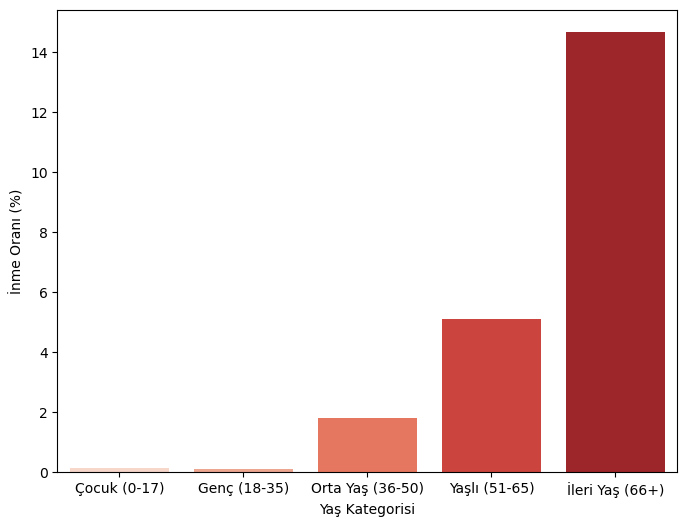

In [52]:
#Grafiktende anlayabileceğimiz şekilde ileri yaş aralığında inme oranı çok yüksek 
plt.figure(figsize=(8,6))

ax = sns.barplot(
    x=inme_orani_age.index, 
    y=inme_orani_age.values, 
    palette="Reds", 
    hue=inme_orani_age.index, 
    dodge=False
)

if ax.legend_:
    ax.legend_.remove()

plt.ylabel("İnme Oranı (%)")
plt.xlabel("Yaş Kategorisi")
plt.show()

In [ ]:
df['bmi_category'] = pd.cut(df['bmi'],
    bins=[0, 18.5, 25, 30, 100],
    labels=['Zayıf (<18.5)','Normal (18.5-25)','Fazla Kilolu (25-30)','Obez (>30)'])

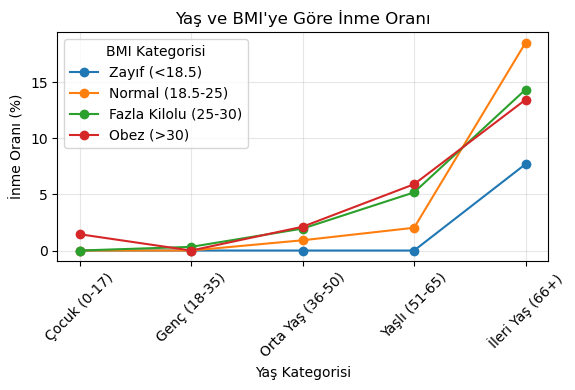

In [71]:
pivot = df.groupby(['age_category','bmi_category'], observed=False)['stroke'].mean().unstack() * 100

plt.figure(figsize=(6,4))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker='o', label=col)

plt.ylabel("İnme Oranı (%)")
plt.xlabel("Yaş Kategorisi")
plt.title("Yaş ve BMI'ye Göre İnme Oranı")
plt.legend(title="BMI Kategorisi")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# İnme riski yaşla birlikte belirgin şekilde artmaktadır. Orta yaş ve yaşlı gruplarda BMI arttıkça inme oranı yükselir.

In [62]:
df['glucose_category'] = pd.cut(df['avg_glucose_level'],
    bins=[0, 100, 125, 200, 300],
    labels=['Normal (<100)','Yüksek (100-125)','Çok Yüksek (125-200)','Tehlikeli (>200)'])

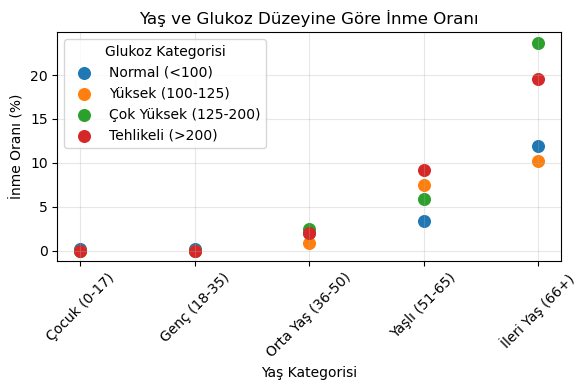

In [70]:
pivot = df.groupby(['age_category','glucose_category'], observed=False)['stroke'].mean().unstack() * 100

plt.figure(figsize=(6,4))
for col in pivot.columns:
    plt.scatter(pivot.index, pivot[col], s=70, label=col)

plt.ylabel("İnme Oranı (%)")
plt.xlabel("Yaş Kategorisi")
plt.title("Yaş ve Glukoz Düzeyine Göre İnme Oranı")
plt.legend(title="Glukoz Kategorisi")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
# İnme riski yaşla birlikte artmaktadır. Orta yaştan itibaren yüksek ve çok yüksek glukoz düzeyleri inme oranını belirgin şekilde artırmaktadır.

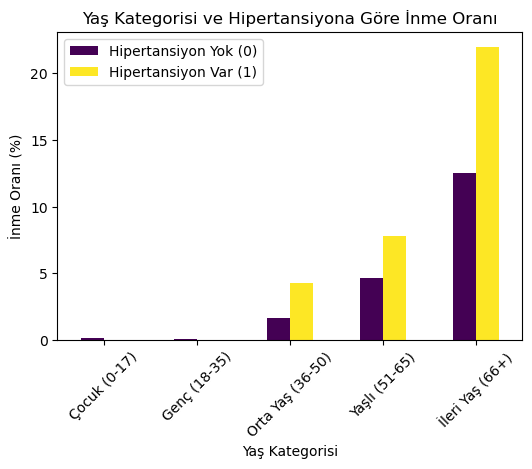

In [34]:
#Yaş aralıklarına göre hipertansiyonu olan kişilerin ve olmayan kişilerin inme geçirme oranı
pivot = df.groupby(['age_category','hypertension'],observed=False)['stroke'].mean().unstack() * 100
pivot.plot(kind='bar', figsize=(6,4), colormap='viridis')
plt.ylabel("İnme Oranı (%)")
plt.xlabel("Yaş Kategorisi")
plt.title("Yaş Kategorisi ve Hipertansiyona Göre İnme Oranı")
plt.xticks(rotation=45)
plt.legend(["Hipertansiyon Yok (0)", "Hipertansiyon Var (1)"])
plt.show()
# Yaşın artması ve hipertansiyon hastalığının varlığı inme riskini arttırıyor

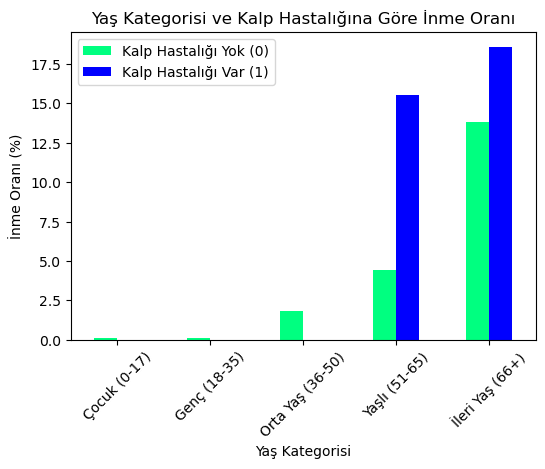

In [35]:
pivot = df.groupby(['age_category','heart_disease'],observed=False)['stroke'].mean().unstack() * 100
pivot.plot(kind='bar', figsize=(6,4), colormap='winter_r')
plt.ylabel("İnme Oranı (%)")
plt.xlabel("Yaş Kategorisi")
plt.title("Yaş Kategorisi ve Kalp Hastalığına Göre İnme Oranı")
plt.xticks(rotation=45)
plt.legend(["Kalp Hastalığı Yok (0)", "Kalp Hastalığı Var (1)"])
plt.show()
# Yaş ilerledikçe kalp hastalığı artıyor 51-65 yaş arası kalp hastalığı olanların olmayanlara göre inme geçirme oranı tam 4 kat fazla

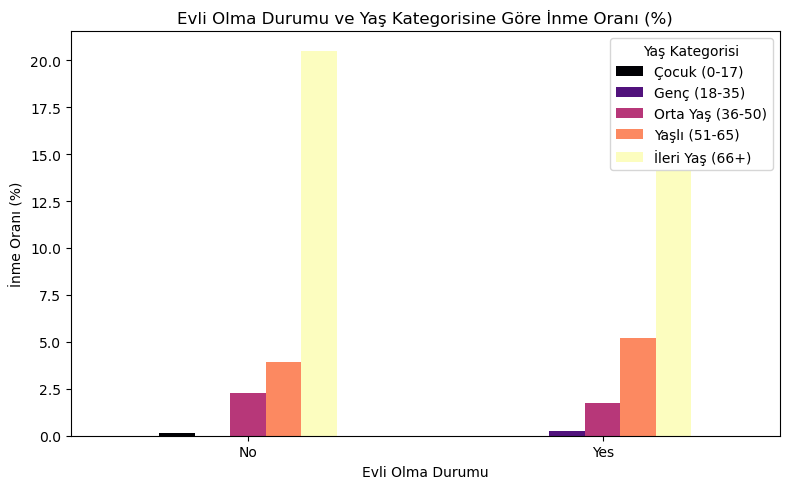

In [ ]:
# evli olma durumunun yaş ile inme oranına bir etkisi varmı gözlemleyelim
pivot = df.groupby(['ever_married','age_category'],observed=False)['stroke'].mean().unstack() * 100
pivot.plot(kind='bar', figsize=(8,5), colormap='magma')
plt.title("Evli Olma Durumu ve Yaş Kategorisine Göre İnme Oranı (%)")
plt.ylabel("İnme Oranı (%)")
plt.xlabel("Evli Olma Durumu")
plt.xticks(rotation=0)
plt.legend(title="Yaş Kategorisi")
plt.tight_layout()
plt.show()
# İnme oranları hem evli hem evli olmayan bireylerde yaşla birlikte artmaktadır.
# Bu artış büyük ölçüde yaşın doğal etkisinden kaynaklanmaktadır.

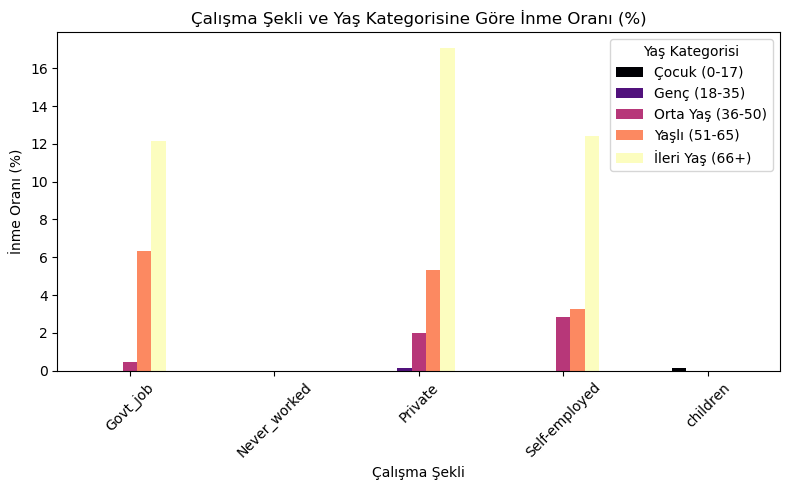

In [ ]:
pivot = df.groupby(['work_type','age_category'],observed=False)['stroke'].mean().unstack() * 100

pivot.plot(kind='bar', figsize=(8,5), colormap='magma')
plt.title("Çalışma Şekli ve Yaş Kategorisine Göre İnme Oranı (%)")
plt.ylabel("İnme Oranı (%)")
plt.xlabel("Çalışma Şekli")
plt.xticks(rotation=45)
plt.legend(title="Yaş Kategorisi")
plt.tight_layout()
plt.show()
# Çalışma tipi kategorileri incelendiğinde tüm gruplarda inme oranlarının yaşla birlikte arttığı görülmektedir. 
# Dolayısıyla çalışma tipi tek başına inme riskini belirleyen bir faktör olarak görünmemektedir

In [ ]:
# Genel Sonuç
# Bu proje sonucunda, inme riskini en çok etkileyen temel faktörler belirlenmiştir:
# Hipertansiyon
# Kalp hastalığı
# Yaş
# Diğer değişkenlerin etkileri daha sınırlı görünmekte ve çoğunlukla yaş ile ilişkili ikincil yansımalar olarak değerlendirilmektedir.

In [40]:
!pip uninstall scikit-learn imbalanced-learn -y
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

     ---------------------------------------- 0.0/7.3 MB ? eta -:--:--
     - -------------------------------------- 0.3/7.3 MB ? eta -:--:--
     ---- ----------------------------------- 0.8/7.3 MB 2.0 MB/s eta 0:00:04
     ----- ---------------------------------- 1.0/7.3 MB 2.1 MB/s eta 0:00:03
     ------- -------------------------------- 1.3/7.3 MB 1.8 MB/s eta 0:00:04
     -------- ------------------------------- 1.6/7.3 MB 1.5 MB/s eta 0:00:04
     -------- ------------------------------- 1.6/7.3 MB 1.5 MB/s eta 0:00:04
     ---------- ----------------------------- 1.8/7.3 MB 1.2 MB/s eta 0:00:05
     ---------- ----------------------------- 1.8/7.3 MB 1.2 MB/s eta 0:00:05
     ----------- ---------------------------- 2.1/7.3 MB 1.1 MB/s eta 0:00:05
     ----------- ---------------------------- 2.1/7.3 MB 1.1 MB/s eta 0:00:05
     ------------ --------------------------- 2.4/7.3 MB 1.1 MB/s eta 0:00:05
     -------------- ------------------------- 2.6/7.3 MB 1.1 MB/s eta 0:00:05


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [45 lines of output]
      Partial import of sklearn during the build process.
      Traceback (most recent call last):
        File "C:\Users\melik\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "C:\Users\melik\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\melik\miniconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 175, in prepare_metadata_for_build_wheel
          return hook(metadata_directory, config_settings)
        File "C:\Users\melik\AppData\Local\Temp\pip-build-env-w4ei5wpf\overlay\Lib\site-packages\s

In [41]:
#EDA kısmı tamamlandı ML adımına geçiyoruz.

#Veri setimiz dengesiz olduğu için doğruluk (accuracy) yerine duyarlılık (Recall) ve F1-Score gibi metriklere odaklanacağız.
#Adım 1: Veri Ön İşleme (Preprocessing)

#Modellerin sayısal verilerle çalışabilmesi için kategorik verileri dönüştürmemiz ve gereksiz sütunları atmamız gerekir.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Gereksiz sütunları çıkaralım
# 'id' tahmin için gereksizdir. 
# 'age_category' görselleştirme içindi, model için orjinal sayısal 'age' sütunu daha değerlidir.
df_ml = df.drop(['id', 'age_category'], axis=1, errors='ignore')

# 2. Kategorik Değişkenleri Dönüştürme (One-Hot Encoding)
# Gender, marriage, work_type gibi text verileri sayıya çeviriyoruz.
df_ml = pd.get_dummies(df_ml, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)

# 3. Bağımlı (y) ve Bağımsız (X) Değişkenleri Ayırma
X = df_ml.drop('stroke', axis=1) # Özellikler
y = df_ml['stroke']              # Hedef (Tahmin edilecek)

# 4. Eğitim ve Test Setine Ayırma
# Verinin %80'i ile modeli eğiteceğiz, %20'si ile test edeceğiz.
# stratify=y kullanıyoruz ki inme geçirenlerin oranı her iki sette de dengeli olsun.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Özellik Ölçeklendirme (Scaling)
# Yaş 80, glikoz 200 olabilir ama hipertansiyon 0-1 arasındadır. 
# Bu farkı kapatmak için standartlaştırma yapıyoruz.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Eğer ölçeklendirme yapmasaydık; model, 220 sayısını 1 sayısından matematiksel olarak çok büyük göreceği için, "Şeker seviyesi, tansiyondan 220 kat daha önemli" gibi yanlış bir karar verecekti. Bu yüzden eşit şarta getirdik.

In [42]:
#Adım 2: Dengesiz Veri ile Başa 

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# 2. Model Kurma
model = RandomForestClassifier(class_weight='balanced', random_state=42)
#class_weight balanced kullanarak yanlışta cezayı artırma gibi bi parametre oldu yani

# Modeli eğit
model.fit(X_train, y_train)

# Tahmin ve Rapor
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       940
           1       0.00      0.00      0.00        42

    accuracy                           0.95       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.95      0.93       982



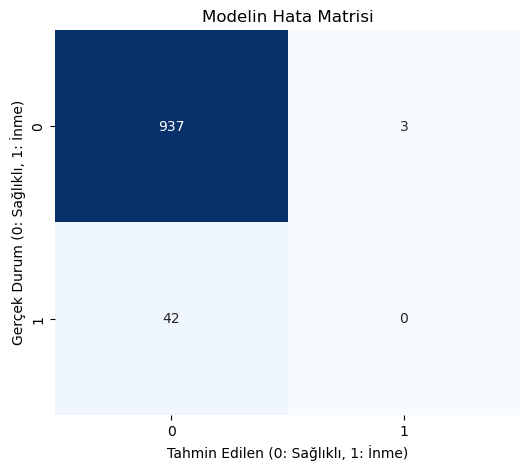

In [43]:
from sklearn.metrics import confusion_matrix

#Matrisi hesapla
cm = confusion_matrix(y_test, y_pred)

#Görselleştir
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Tahmin Edilen (0: Sağlıklı, 1: İnme)')
plt.ylabel('Gerçek Durum (0: Sağlıklı, 1: İnme)')
plt.title('Modelin Hata Matrisi')
plt.show()

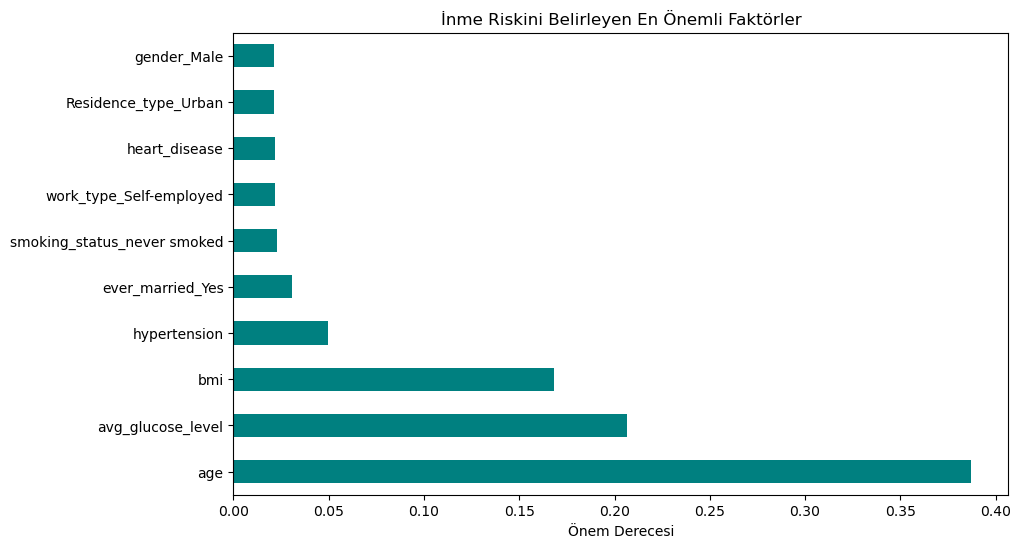

In [44]:
#Özellik önem düzeylerini al

feature_importances = pd.Series(model.feature_importances_, index=X.columns)

#En önemli 10 özelliği görselleştir
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title('İnme Riskini Belirleyen En Önemli Faktörler')
plt.xlabel('Önem Derecesi')
plt.show()

In [ ]:
#RandomForest modelini kurduk şimdi birde lojistik regresyon modeli kuracağız ve hangi modelin duyarlılık değeri daha yüksek buna bakacağız.

In [46]:
from sklearn.linear_model import LogisticRegression

# 1. Modeli Kur
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# 2. Eğit
log_model.fit(X_train, y_train)

# 3. Tahmin Et
y_pred_log = log_model.predict(X_test)

# 4. Sonuçları Kıyasla
print("--- Logistic Regression Sonuçları ---")
print(classification_report(y_test, y_pred_log))

--- Logistic Regression Sonuçları ---
              precision    recall  f1-score   support

           0       0.98      0.75      0.85       940
           1       0.11      0.71      0.20        42

    accuracy                           0.75       982
   macro avg       0.55      0.73      0.52       982
weighted avg       0.95      0.75      0.82       982



--- Model Karşılaştırma Tablosu ---
                 Model  Accuracy (Doğruluk)  Recall (Duyarlılık)  F1-Score  \
0        Random Forest                0.954                0.000     0.000   
1  Logistic Regression                0.751                0.714     0.197   

   AUC Score  
0      0.737  
1      0.803  


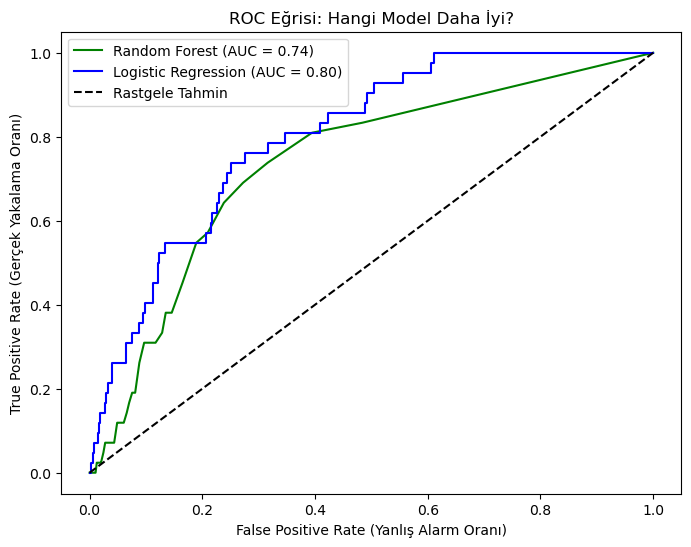

In [47]:
#Modelleri karşılaştırıyoruz.

from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve

# 1. Metrikleri Hesaplama Fonksiyonu
def get_metrics(model_name, y_true, y_pred, y_prob):
    return {
        'Model': model_name,
        'Accuracy (Doğruluk)': accuracy_score(y_true, y_pred),
        'Recall (Duyarlılık)': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC Score': roc_auc_score(y_true, y_prob)
    }

#Random Forest Tahminleri
y_pred_rf = model.predict(X_test)
y_prob_rf = model.predict_proba(X_test)[:, 1] # Olasılık değerleri (1 sınıfı için)

#Lojistik Regresyon Tahminleri
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

#Sonuçları Tabloya Dökme
results = pd.DataFrame([
    get_metrics('Random Forest', y_test, y_pred_rf, y_prob_rf),
    get_metrics('Logistic Regression', y_test, y_pred_log, y_prob_log)
])

print("--- Model Karşılaştırma Tablosu ---")
print(results.round(3))

# --- 2. ROC Eğrisi Çizimi (Görsel Karşılaştırma) ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)

plt.figure(figsize=(8, 6))

# Random Forest Çizgisi
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})', color='green')

# Logistic Regression Çizgisi
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_log):.2f})', color='blue')

# Rastgele Tahmin Çizgisi (Referans)
plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Tahmin')

plt.xlabel('False Positive Rate (Yanlış Alarm Oranı)')
plt.ylabel('True Positive Rate (Gerçek Yakalama Oranı)')
plt.title('ROC Eğrisi: Hangi Model Daha İyi?')
plt.legend()
plt.show()

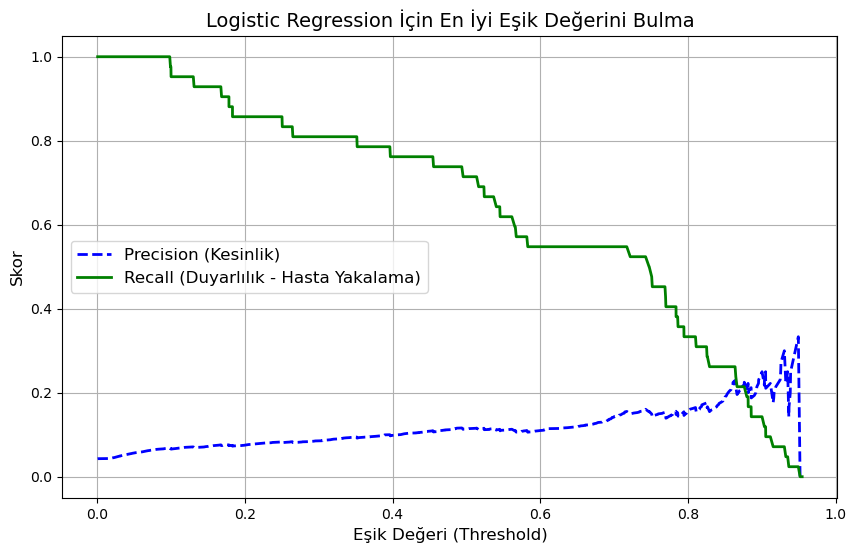

In [48]:
#Lojistik regresyon daha iyi olduğu için bu model üstünden confusion matrix çıkaracağız.

from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(y_test, y_probs, model_name):
    # Precision, Recall ve Threshold değerlerini hesapla
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
    
    # Grafiği çiz
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision (Kesinlik)", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall (Duyarlılık - Hasta Yakalama)", linewidth=2)
    
    plt.xlabel("Eşik Değeri (Threshold)", fontsize=12)
    plt.ylabel("Skor", fontsize=12)
    plt.title(f"{model_name} İçin En İyi Eşik Değerini Bulma", fontsize=14)
    plt.legend(loc="center left", fontsize=12)
    plt.grid(True)
    plt.show()

#Lojistik Regresyon için Analiz
#y_prob_log değişkeni önceki adımlardan hafızada olmalı
plot_precision_recall_vs_threshold(y_test, y_prob_log, "Logistic Regression")

--- SEÇİLEN EŞİK DEĞERİ: 0.3 ---

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       940
           1       0.09      0.81      0.15        42

    accuracy                           0.62       982
   macro avg       0.54      0.71      0.46       982
weighted avg       0.95      0.62      0.73       982



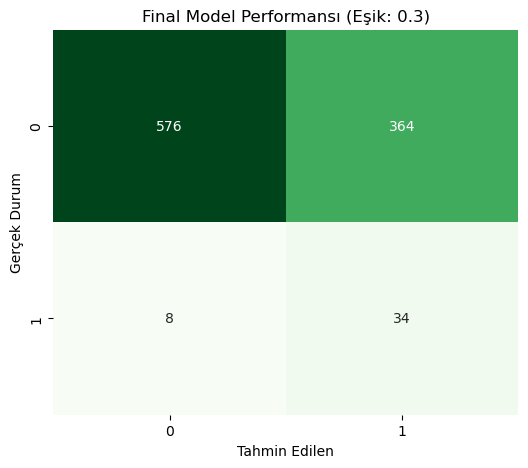

In [49]:
#Final Modeli

final_threshold = 0.3

#Modelin ürettiği olasılıkları bu eşiğe göre 1 veya 0'a çeviriyoruz
y_pred_final = (y_prob_log >= final_threshold).astype(int)

#Sonuçları Raporlama
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(f"--- SEÇİLEN EŞİK DEĞERİ: {final_threshold} ---")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred_final))

#Final Confusion Matrix
plt.figure(figsize=(6, 5))
cm_final = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title(f'Final Model Performansı (Eşik: {final_threshold})')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Durum')
plt.show()